# This notebook

Explores the x and y parameters in the plot

In [1]:
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle


import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/codes'))
from jason import plotting_def, plot_prettier

plotting_def()

In [18]:
import pickle

# trial = '240606_0.6_5'  # for 4e4 plot
# trial = '240610_0.6_2032'  # for 8e3 plot

trial = '240610_0.6_2032'

datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

In [19]:
rp

{'trial': '240610_0.6_2032',
 'cloud_flag': True,
 'T_cloud': 8000.0,
 'cloud_radius': 0.005,
 'cloud_pos': [0, 0, 0],
 'box_size': 0.1,
 'grid_dim': 128,
 'grid_vol': 2097152,
 'grid_mesh': 32,
 'T_floor': 8000.0,
 'T_cold': 8000.0,
 'T_ceil': 100000000.0,
 'cooling_flag': True,
 'T_hot': 4000000.0,
 'rho_hot': 0.1,
 'mach': 0.6,
 'T_cut': 1000000.0,
 'chi': 500.0,
 'P_hot': 8.438675409534824e-14,
 'v_turb': 0.1865317171670572,
 't_eddy': 0.5361018572001904,
 'cs_hot': 0.31088619527842865,
 'T_mix': 178885.43819998318,
 'T_warm': 178885.43819998318,
 'dedt': 3.2450998855893037e-06,
 't_corr': 0.5361018572001904,
 'dt_drive': 0.0005361018572001905,
 't_cc': 0.5993800977817555,
 't_maxc': 0.5993800977817555,
 'time_start': 5.993800977817555,
 'time_end': 11.98760195563511,
 'dt_hdf5': 0.05993800977817555,
 'time_cloud': 5.993800977817555}

In [20]:
"""Define constants"""

class unit():
    def __init__(self):        
        # length, time, and mass constants
        self.CONST_pc  = 3.086e18
        self.CONST_yr  = 3.154e7
        self.CONST_amu = 1.66053886e-24
        self.CONST_kB  = 1.3806505e-16
        self.unit_length = self.CONST_pc*1e3  # 1 kpc
        self.unit_time   = self.CONST_yr*1e6  # 1 Myr
        self.unit_density = self.CONST_amu    # 1 mp/cm-3
        self.unit_velocity = self.unit_length/self.unit_time
        self.KELVIN = self.unit_velocity*self.unit_velocity*self.CONST_amu/self.CONST_kB
        self.unit_q = (self.unit_density * (self.unit_velocity**3))/self.unit_length
        self.g = 5/3
        
        # avg atomic mass
        Xsol = 1.0
        Zsol = 1.0
        
        X = Xsol * 0.7381
        Z = Zsol * 0.0134
        Y = 1 - X - Z
        
        self.mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
        self.mue = 2.0/(1.0+X);
        self.muH = 1.0/X;
        self.mH = 1.0

        # alpha values for different sims
        self.alpha_hyd = 2 ** (1 / 3)  # 1.26 # 1.383
        self.alpha_mhd = (2 * 4.2 / 0.77) ** (1 / 3)

u = unit()
u.mu

0.5990624672387714

In [21]:
def calc_T(P, rho):
    """
    Calculates temeprature from constants
    ----------
    P: gas pressure
    rho: gas density
    """
    T = P/rho * u.KELVIN * u.mu
    return T

def calc_cs(T):
    """
    Calculates sound speed
    ----------
    T: temperature
    mu: avg atomic number of the gas
    """
    # convert to cm
    m_to_cm = 100

    # return np.sqrt(g.g*R*T_hot/M) * m_to_cm/g.unit_velocity
    # return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) * m_to_cm / u.unit_velocity
    return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity

def calc_mach(v_turb, P, rho):
    """
    Calculates the Mach number
    ----------
    v_turb: turbulence velocity
    P, rho
    """
    T = calc_T(P, rho)
    cs = calc_cs(T)
    print(f'cs = {cs}')
    return v_turb / cs

def calc_dedt_mach(mach, P, rho, L):
    """
    Returns required dedt for a given Mach number, density, temperature, and box size
    """
    # calculate sound speed first
    T = calc_T(P, rho)
    cs_new = calc_cs(T)
    print(f"cs_hot: {cs_new}")

    dedt_req = rho * (cs_new**3) * (L**2) * (mach**3) / (u.alpha_hyd**3)
    return dedt_req


def calc_dedt_vturb(v_turb, rho, L):
    """
    Returns required dedt for a given turbulent velocity, density, and box size

    Does NOT calculate sound speed, so no pressure required
    """
    
    dedt_req = rho * v_turb**3 * (L**2) / (u.alpha_hyd**3)
    return dedt_req

def find_ind_l(seq, val):
    seq = list(seq)
    return seq.index(list(filter(lambda x: x>val, seq))[0])

# X axis (Mach number)

In [22]:
rp['mach']

0.6

# Y axis (R_cloud / l_shatter)

## Load l_shatter

In [23]:
# Import the cooling function from Hitesh's scripts
import sys
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/cooling_scripts'))
import cooling_fn as cf
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/helper_scripts'))
import v_turb as vt

In [24]:
# temperature range
T_arr = np.logspace(np.log10(rp['T_floor']),
                    np.log10(rp['T_ceil']), 100)  # in kelvin
rho_arr = rp['rho_hot'] * rp['T_hot'] / T_arr

"""
Cooling & Heating functions
"""
Gamma_n_arr = 1e-26 / rho_arr
Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)

"""
Cooling & Heating rates
"""
heating_rate = 1e-26 * rho_arr
cooling_rate = Lambda_arr * rho_arr**2

"""
Timescale
"""
tcool_arr = np.vectorize(cf.tcool_calc)(
    rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
)

def plot_tvlines():
    plt.axvline(x=rp['T_floor'], color="k", linestyle="--")
    plt.axvline(x=rp['T_cloud'], color="slateblue", linestyle="--")
    plt.axvline(x=rp['T_mix'], color="green", linestyle="--", alpha=0.2)
    plt.axvline(x=rp['T_hot'], color="orangered", linestyle="--")
    # plt.axvline(x=T_cut color="k", linestyle="")

In [25]:
# function for calculating cooling time
t_cool_func = lambda T : cf.tcool_calc(rp['rho_hot'] * rp['T_hot'] / T, T, Zsol=1.0, Lambda_fac=1.0, fit_type="max")

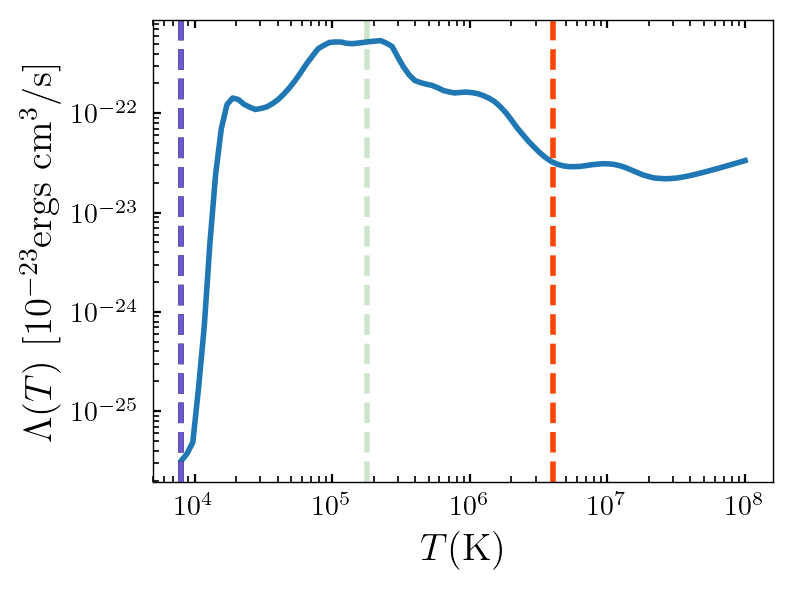

In [26]:
"""Cooling function"""
plt.figure(figsize=(4, 3))
plt.plot(T_arr, Lambda_arr, label=r"$\Lambda(T)$")

plt.ylabel(r"$\Lambda(T)$  $[10^{-23}  \mathrm{ergs ~ cm}^3/\mathrm{s}]$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plot_tvlines()
plt.show()

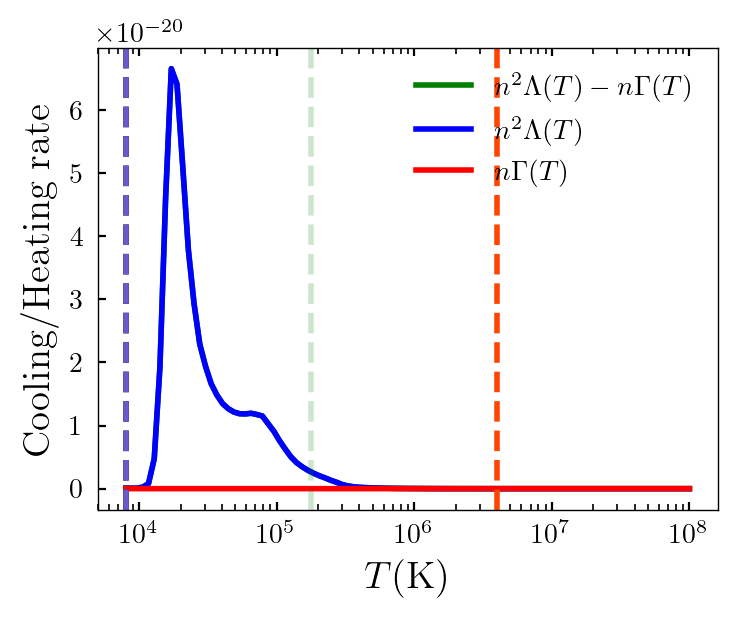

In [27]:
"""Cooling rate"""
plt.figure(figsize=(4, 3))
plt.plot(T_arr, cooling_rate - heating_rate, color='green', label=r"$n^2\Lambda(T) - n\Gamma(T) $")
plt.plot(T_arr, cooling_rate, color='blue', label=r"$n^2\Lambda(T)$")
plt.plot(T_arr, heating_rate, color='red', label=r"$n\Gamma(T)$")

plt.ylabel(r"Cooling/Heating rate", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

# plt.yscale("log")
plt.xscale("log")

# plt.ylim(0.0, 5e-15)

plt.legend()
plot_tvlines()
plt.show()

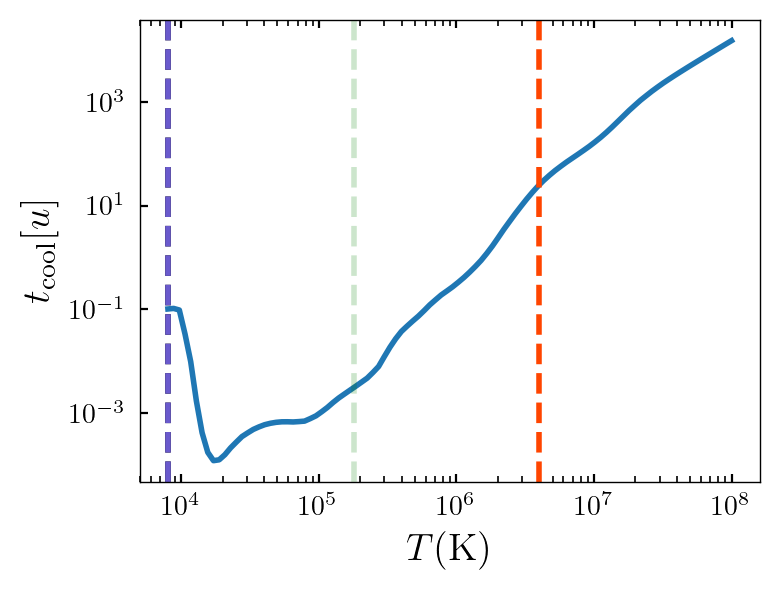

In [28]:
"""Cooling timescale"""
plt.figure(figsize=(4, 3))
plt.plot(T_arr, tcool_arr, label=r"$\Lambda(T)$")

plt.ylabel(r"$t_{\rm cool} [u]$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plot_tvlines()
plt.show()

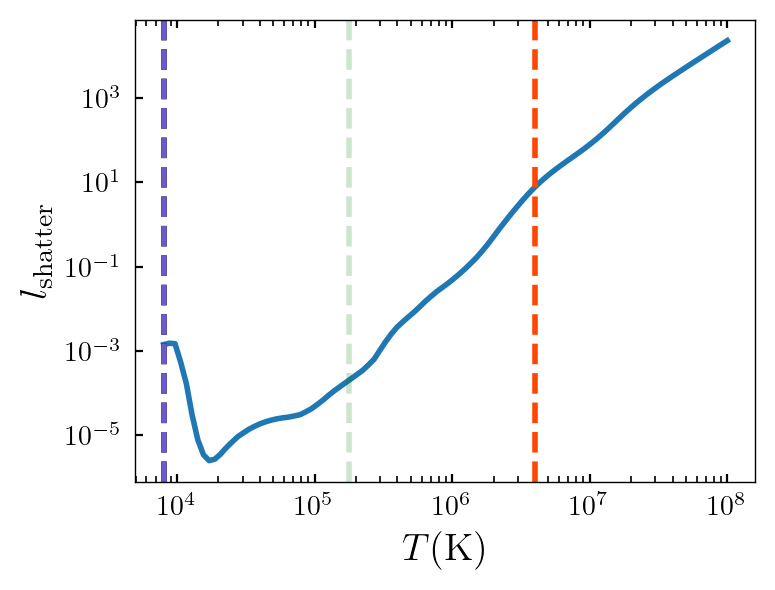

In [29]:
"""l_shatter"""
def calc_cs(T):
    m_to_cm = 100
    return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity
plt.figure(figsize=(4, 3))

# shatter length scale
l_shatter = np.vectorize(t_cool_func)(T_arr) * calc_cs(T_arr)
plt.plot(T_arr, l_shatter)

plt.ylabel(r"$l_{\rm shatter}$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plot_tvlines()
plt.show()

## Mixing

In [30]:
# calculate geometric mean T_mix
# the two limits
T_cold = rp['T_cloud']  # set cold temperature to that of cloud
T_hot = rp['T_hot']

print(f'T_cold = {T_cold}')
print(f'T_hot = {T_hot:.2e}')

# T_mix = np.sqrt(T_cold * T_hot)  # use the cloud temperature
T_mix = np.sqrt(T_cold * T_hot)  # use the temperature at which t_cool is lowest
print(f'T_mix = {T_mix:.2e}')

t_cool_mix = t_cool_func(T_mix)
t_cool_cold = t_cool_func(T_cold)
print(f't_cool,mix = {t_cool_mix:.2e}')
print(f't_cool,cold = {t_cool_cold:.2e}')

t_cool_min = np.min(tcool_arr[find_ind_l(T_arr, T_cold) : find_ind_l(T_arr, T_hot)])
print(f't_cool_min = {t_cool_min:.2e}')

l_shatter_min = np.min(l_shatter[find_ind_l(T_arr, T_cold) : find_ind_l(T_arr, T_hot)])
print(f'l_shatter_min = {l_shatter_min:.2e}')
vel_frac = rp['cloud_radius'] / l_shatter_min

T_cold = 8000.0
T_hot = 4.00e+06
T_mix = 1.79e+05
t_cool,mix = 3.08e-03
t_cool,cold = 1.01e-01
t_cool_min = 1.21e-04
l_shatter_min = 2.46e-06


In [31]:
rp['cloud_radius'], l_shatter_min, np.log10(vel_frac)

(0.005, 2.46054741449215e-06, 3.307938266075897)

## Analytical plot

In [32]:
print(f'X-value = {rp['mach']}')
print(f'Y-value [log] = {np.log10(vel_frac):.3f}')
print(f'Y-value= {vel_frac:.3f}')

X-value = 0.6
Y-value [log] = 3.308
Y-value= 2032.068


/tmp/ipykernel_19541/4241604564.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(rp['mach'], vel_frac, marker='o', vmin=-0.3, vmax=0.3, ec='k', fc='None')
/tmp/ipykernel_19541/4241604564.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


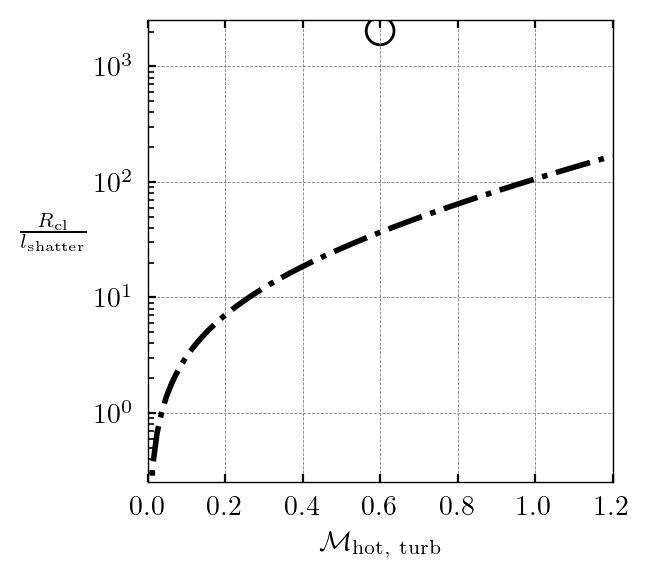

In [33]:
plt.subplots(figsize=(3,3))
cm = plt.colormaps['bwr_r']

# point
sc = plt.scatter(rp['mach'], vel_frac, marker='o', vmin=-0.3, vmax=0.3, ec='k', fc='None')

# analytical line
ana_x = np.linspace(0, 1.2, 100)
ana_y = ana_x * t_cool_mix / t_cool_min * 10. ** (0.6 * ana_x + 0.02)
plt.plot(ana_x, ana_y, ls='-.', color='k')

# axis
plt.xlim(0, 1.2)
plt.xticks(np.linspace(0, 1.2, 7))
plt.ylim(np.power(10., np.log10(t_cool_mix / t_cool_min) - 2), np.power(10., np.log10(t_cool_mix / t_cool_min) + 2))
plt.yscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0, labelpad=15)

# color bar
plt.legend()
plt.grid()
plt.show()

# Color (cold gas fraction)

In [27]:
trial = 'rescaling_conv'  # for 8e3 plot
# trial = '240610_0.6_2032'

datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


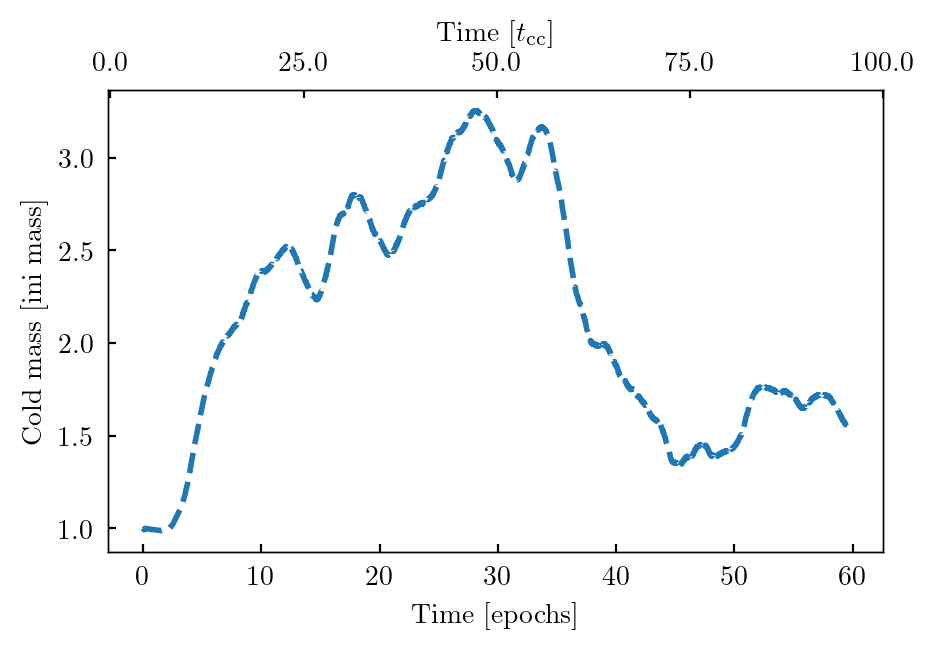

In [35]:
"""
Compare with hist file
"""

# grab the hst file data
fname = f'{datapath}/turb/Turb.hst'
with open(fname, 'r') as file: keys_raw = file.readlines()[1]
keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
fname = f'{datapath}/cloud/Turb.hst'
data = np.loadtxt(fname).T
dataf = {keys[i]: data[i] for i in range(len(keys))}

# plot athdf version
fig, ax1 = plt.subplots(figsize=(5,3))

# plot hst version
cg_st_epoch = 0
ax1.plot(dataf['time'] / rp['dt_hdf5'], dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch], ls='--', label='hst')
# ax1.set_yscale('log')

# ax1.set_yscale('log')
ax1.set_ylabel('Cold mass [ini mass]')
ax1.set_xlabel('Time [epochs]')

# alternative t_cc axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
t_cc_lin = np.linspace(0, 100, 5)
ax2.set_xticks(rp['t_cc'] / rp['dt_hdf5'] * t_cc_lin)
ax2.set_xticklabels(t_cc_lin)
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

plt.legend()
plt.show()

# Param plot

In [34]:
trial_x_val = rp['mach']
trial_y_val = vel_frac
log_mass_frac = np.log10(dataf['cold_gas'][-1] / dataf['cold_gas'][cg_st_epoch])

trial_x_val, trial_y_val, log_mass_frac

(0.6, 2032.06813676947, 0.230690056119909)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


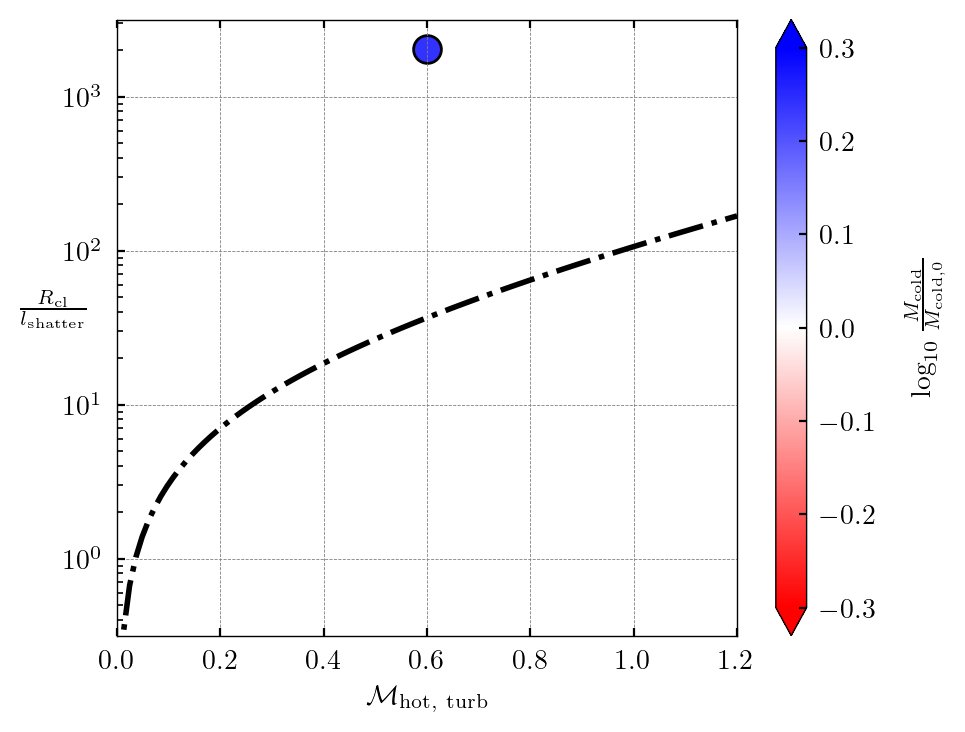

In [32]:
plt.subplots(figsize=(5,4))
cm = plt.colormaps['bwr_r']

# scale the fraction
log_mass_frac = np.clip(log_mass_frac, -1, 1)

# scatter the points
sc = plt.scatter(trial_x_val, trial_y_val, marker='o',
                 c=log_mass_frac, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)

# analytical line
ana_x = np.linspace(0, 1.2, 100)
ana_y = ana_x * t_cool_mix / t_cool_min * 10. ** (0.6 * ana_x + 0.02)
plt.plot(ana_x, ana_y, ls='-.', color='k')

# axis
plt.xlim(0, 1.2)
plt.ylim(np.power(10., -0.5), np.power(10., 3.5))
plt.yscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)

# color bar
cbar = plt.colorbar(sc, extend='both')
cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
plt.legend()
plt.grid()
plt.show()

In [27]:
# add the params to file
import pandas as pd
csvpath = f'/freya/ptmp/mpa/wuze/data/cloud_hitesh.csv'
df = pd.read_csv(csvpath, index_col=False, comment='#')
# display(df)

params_dict = {
    'trial' : trial,
    'x_mach' : trial_x_val,
    'y' : trial_y_val,
    'r_cl' : rp['cloud_radius'],
    'l_shat' : l_shatter_min,
    'log_cloud_mass' : log_mass_frac,
    'T_cloud' : rp['T_cloud'],
    'T_floor' : rp['T_floor'],
    'chi' : rp['chi'],
}

# save trial in csv
print(trial)
if trial in list(df['trial']):  # if exists
    trial_ind = df.index[df['trial'] == trial][0]
    for col, val in params_dict.items():
        df.at[trial_ind, col] = val
else:  # if no row with trial name, make one
    new_row = pd.DataFrame(params_dict, index=[0])
    df = pd.concat([df, new_row], ignore_index=True)

# save updated csv
display(df)
df.to_csv(csvpath, index=False)

240606_0.6_5


,trial,x_mach,y,r_cl,l_shat,log_cloud_mass,T_cloud,T_floor,chi
0,240606_0.6_5,0.6,5.430815,0.0001,0.000018,-1.0,40000.0,40000.0,100.0
1,240607_0.6_271,0.6,271.540744,0.0050,0.000018,1.0,40000.0,40000.0,100.0


## All params

In [28]:
import pandas as pd
csvpath = f'/freya/ptmp/mpa/wuze/data/cloud_hitesh.csv'
df = pd.read_csv(csvpath, comment='#')

all_x = df['x_mach'].to_numpy()
all_y = df['y'].to_numpy()
all_color = df['log_cloud_mass'].to_numpy()

# set cloud and floor temperature text
if df['T_cloud'][0] == 8e3:
    text_T_cloud = r'$T_{\rm cloud} = 8\times 10^3$'
elif df['T_cloud'][0] == 4e4:
    text_T_cloud = r'$T_{\rm cloud} = 4\times 10^4$'
elif df['T_cloud'][0] == 8e2:
    text_T_cloud = r'$T_{\rm cloud} = 8\times 10^2$'

if df['T_floor'][0] == 8e3:
    text_T_floor = r'$T_{\rm floor} = 8\times 10^3$'
elif df['T_floor'][0] == 4e4:
    text_T_floor = r'$T_{\rm cloud} = 4\times 10^4$'
elif df['T_floor'][0] == 8e2:
    text_T_floor = r'$T_{\rm cloud} = 8\times 10^2$'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


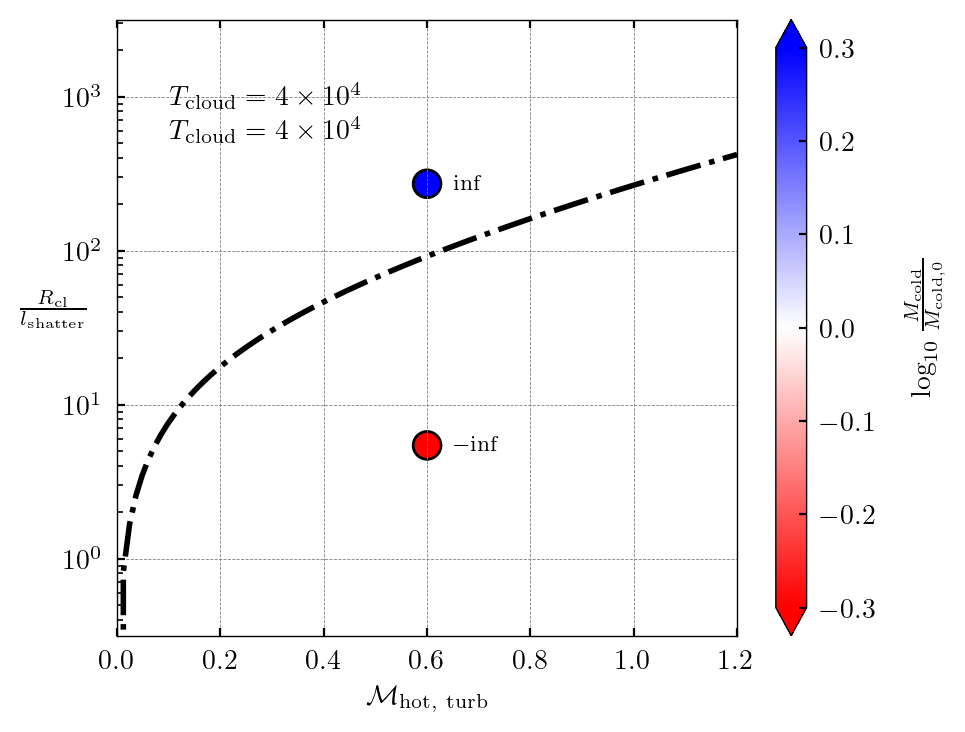

In [29]:
plt.subplots(figsize=(5,4))
cm = plt.colormaps['bwr_r']

# scale the fraction
all_color = np.clip(all_color, -1, 1)

# scatter the points
sc = plt.scatter(all_x, all_y, marker='o',
                 c=all_color, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)

# annotate with its color value
for i in range(len(all_x)):
    col = all_color[i]
    if col == 1: col = np.inf
    elif col == -1: col = -np.inf
    col = f'{col:.2f}'.replace('-', '\N{MINUS SIGN}')
    plt.text(all_x[i] + 0.05, all_y[i], col, fontsize=8, ha='left', va='center')


# label the temperatures
plt.text(0.1, 1e3, text_T_cloud, fontsize=10, ha='left', va='center')
plt.text(0.1, 6e2, text_T_floor, fontsize=10, ha='left', va='center')

# analytical line
ana_x = np.linspace(0, 1.2, 100)
ana_y = ana_x * t_cool_mix / t_cool_min * 10. ** (0.6 * ana_x + 0.02)
plt.plot(ana_x, ana_y, ls='-.', color='k')

# axis
plt.xlim(0, 1.2)
plt.ylim(np.power(10., -0.5), np.power(10., 3.5))
plt.yscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)

# color bar
cbar = plt.colorbar(sc, extend='both')
cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
plt.legend()
plt.grid()
plt.show()